In [188]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

# 设定随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用多个 GPU
    torch.backends.cudnn.deterministic = True  # 保证卷积等操作的确定性
    torch.backends.cudnn.benchmark = False  # 禁用某些优化，保证结果稳定

# 设置随机种子
set_seed(42)

# ---------------------------
# 神经网络定义
# ---------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=[50, 50, 50], activation='tanh'):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size[0]))
        if activation == 'tanh':
            layers.append(nn.Tanh())
        elif activation == 'swish':
            layers.append(nn.SiLU())  # Swish 激活函数
        for i in range(len(hidden_size)-1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size[-1], 2))  # 输出 A(x) 和 Φ(x)
        self.network = nn.Sequential(*layers)

        # Xavier初始化
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

# ---------------------------
# 自动微分工具
# ---------------------------
def auto_grad(u, x, order=1, allow_unused=False):
    if order == 1:
        grad_outputs = torch.ones_like(u, requires_grad=True)
        return torch.autograd.grad(
            u, x, grad_outputs=grad_outputs,
            retain_graph=True, create_graph=True, allow_unused=allow_unused
        )[0]
    else:
        return auto_grad(auto_grad(u, x, allow_unused=True), x, order=order-1, allow_unused=allow_unused)

# ---------------------------
# 解析解定义 Np
# ---------------------------
def T_anal(x, t, T0, A, W, k, omega, phi):
    """ 温度场的解析解公式 """
    term1 = -W/(2*k)*x
    sqrt_term = np.sqrt(W**4 + 16*k**2*omega**2)
    term2 = (np.sqrt(2)/(4*k)) * np.sqrt(W**2 + sqrt_term) * x
    exp_factor = np.exp(term1 - term2)

    phase = omega*t + phi
    spatial_term = (np.sqrt(2)*omega)/np.sqrt(W**2 + sqrt_term) * x
    sine_factor = np.sin(phase - spatial_term)

    return T0 + A * exp_factor * sine_factor
    
# ---------------------------
# 解析解定义 Tensor
# ---------------------------
def T_anal_tensor(x, t, T0, A, W, k, omega, phi):
    """ 温度场的解析解公式 """
    # 使用 PyTorch 张量操作
    term1 = -W / (2 * k) * x
    sqrt_term = torch.sqrt(W**4 + 16 * k**2 * omega**2)
    term2 = (torch.sqrt(torch.tensor(2.0)) / (4 * k)) * torch.sqrt(W**2 + sqrt_term) * x
    exp_factor = torch.exp(term1 - term2)

    phase = omega * t + phi
    spatial_term = (torch.sqrt(torch.tensor(2.0)) * omega / torch.sqrt(W**2 + sqrt_term)) * x
    sine_factor = torch.sin(phase - spatial_term)

    return T0 + A * exp_factor * sine_factor

# ---------------------------
# PINNs反演模型
# ---------------------------
class PINNsInverse:
    def __init__(self, layers, T0, omega, phi0, activation='tanh', device='cpu', lr=0.001, k_min=0, k_max=0, W_min=0, W_max=0):
        self.device = device
        self.dnn = NeuralNetwork(layers[0], layers[1:-1], activation).to(device)
        self.T0 = torch.tensor(T0, dtype=torch.float32, device=device)
        self.omega = torch.tensor(omega, dtype=torch.float32, device=device)
        self.phi0 = torch.tensor(phi0, dtype=torch.float32, device=device)
        
        # 设置 k 和 W 的范围
        self.k_min = k_min
        self.k_max = k_max
        self.W_min = W_min
        self.W_max = W_max
        

        # 参数初始化（严格限制范围）
        self.k = nn.Parameter(
            torch.clamp(torch.rand(1, device=device) * (k_max - k_min) + k_min, k_min, k_max),
            requires_grad=True
        )
        self.W = nn.Parameter(
            torch.clamp(torch.rand(1, device=device) * (W_max - W_min) + W_min, W_min, W_max),
            requires_grad=True
        )

        # 优化器配置
        # self.optimizer = optim.Adam([{'params': self.dnn.parameters()}, {'params': [self.k, self.W]}], lr=lr)
        self.optimizer = optim.Adam([
            {'params': self.dnn.parameters(), 'lr': 1e-3},
            {'params': [self.k], 'lr': 1e-8},  # k 学习率更小
            {'params': [self.W], 'lr': 1e-8}
        ])
        # self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.9)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000)

        # 损失记录
        self.loss_history = []
        self.pde_loss_history = []
        self.bc1_loss_history = []  # 边界条件 1 (x=0)
        self.bc2_loss_history = []  # 边界条件 2 (x=0.2)
        self.ic_loss_history = []


    def train(self, epochs, x_train, t_train, S1_bc, S2_bc):
        """ 训练过程 """
        # 使用 meshgrid 生成网格数据
        X, T = np.meshgrid(x_train, t_train)
        X_flat = X.reshape(-1, 1)
        T_flat = T.reshape(-1, 1)

        # 转换数据为Tensor并移动到GPU
        x_tensor = torch.tensor(X_flat, requires_grad=True, dtype=torch.float32, device=self.device)
        t_tensor = torch.tensor(T_flat, requires_grad=True, dtype=torch.float32, device=self.device)
        S1_tensor = torch.tensor(S1_bc, dtype=torch.float32, device=self.device)
        S2_tensor = torch.tensor(S2_bc, dtype=torch.float32, device=self.device)
        T_ic_tensor = torch.tensor(T_ic, dtype=torch.float32, device=self.device)

        # 训练循环
        for epoch in range(epochs):
            self.optimizer.zero_grad()

            # 神经网络预测 A(x) 和 Φ(x)
            outputs = self.dnn(x_tensor)
            A = outputs[:, 0].unsqueeze(1)  # A(x), 形状 (N, 1)
            A = torch.exp(A)  # 使用 Sigmoid 函数将 A 转换到 (0, 1)

            Phi = outputs[:, 1].unsqueeze(1)  # Φ(x), 形状 (N, 1)
            Phi = (Phi + torch.pi) % (2 * torch.pi) - torch.pi  # 变换到 [-π, π] 区间

            # 生成解 T(x,t)
            phase = self.omega * t_tensor + Phi + self.phi0  # 形状 (N, 1)
            T = self.T0 + A * torch.sin(phase)  # 形状 (N, 1)

            # ========== 损失计算 ==========
            # 1. PDE残差
            T_t = auto_grad(T, t_tensor)  # ∂T/∂t
            T_x = auto_grad(T, x_tensor)  # ∂T/∂x
            T_xx = auto_grad(T_x, x_tensor)  # ∂²T/∂x²

            pde_res = T_t - self.k * T_xx - self.W * T_x
            pde_loss = torch.mean(pde_res**2)

            # 2. 边界条件 1 (x=0处)
            bc1_mask = (x_tensor == 0).squeeze()
            if bc1_mask.any():
                bc1_loss = torch.mean((T[bc1_mask] - S1_tensor)**2)
            else:
                bc1_loss = torch.tensor(0.0, device=self.device)

            # 3. 边界条件 2 (x=0.2处)
            bc2_mask = (x_tensor == 0.2).squeeze()
            if bc2_mask.any():
                bc2_loss = torch.mean((T[bc2_mask] - S2_tensor)**2)
            else:
                bc2_loss = torch.tensor(0.0, device=self.device)
 
            # 总损失（包含正则化）

            # # 动态调整权重
            if epoch < 0:  # 训练初期，重点优化初始条件
                total_loss = 1e1 * (1 * bc1_loss + 1 * bc2_loss )
            elif epoch < 3000:  # 逐步加入 PDE 和边界条件
                total_loss = 1e12 * pde_loss + 1 * bc1_loss + 1 * bc2_loss 
            else:  # 训练后期，平衡所有损失
                total_loss = 1e9 * pde_loss + 1 * bc1_loss + 1 * bc2_loss 

            # ========== 反向传播 ==========
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            # 记录损失
            self.loss_history.append(total_loss.item())
            self.pde_loss_history.append(pde_loss.item())
            self.bc1_loss_history.append(bc1_loss.item())
            self.bc2_loss_history.append(bc2_loss.item())

           # 强制参数在范围内（在优化步骤之后）
            with torch.no_grad():
                self.k.data.clamp_(self.k_min, self.k_max)
                self.W.data.clamp_(self.W_min, self.W_max)

            if epoch % 500 == 0:
                print(f"Epoch {epoch:5d} | Total Loss: {total_loss.item():.3e} | "
                      f"PDE: {pde_loss.item():.3e} | BC1: {bc1_loss.item():.3e} | "
                      f"BC2: {bc2_loss.item():.3e} | "
                      f"k: {self.k.item():.3e} | W: {self.W.item():.3e}")
    def predict(self, x):
        """ 预测 A(x) 和 Φ(x) """
        self.dnn.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32, device=self.device)
            outputs = self.dnn(x_tensor)
            A = np.exp(outputs[:, 0].cpu().numpy())
            Phi = outputs[:, 1].cpu().numpy()
            Phi = (Phi + torch.pi) % (2 * torch.pi) - torch.pi  # 变换到 [-π, π] 区间
            return A, Phi

# ---------------------------
# 参数配置
# ---------------------------
# 物理参数
T0 = 0.0       # 基础温度
omega = 2*np.pi/(24*3600)  # 角频率 (rad/s)
phi0 = 0.0     # 初始相位
A_anal = 1.0   # 解析解振幅
k_true = 1e-6  # 真实扩散系数
W_true = 1e-6 # 真实对流系数

# 空间和时间参数
x_min, x_max = 0.0, 0.2   # 空间范围 (m)
t_min, t_max = 0.0, 1*24*3600  # 时间范围 (s)
num_x = 100              # 空间采样点数
num_t = 50               # 时间采样点数

# 训练参数
hidden_layers = [200, 200, 200]  # 神经网络结构
epochs = 100000               # 训练轮数
lr = {1e-3,1e-8,1e-8}                   # 初始学习率

# ---------------------------
# 数据生成
# ---------------------------
# 生成训练数据
x_vals = np.linspace(x_min, x_max, num_x).reshape(-1, 1)
t_vals = np.linspace(t_min, t_max, num_t).reshape(-1, 1)

# 使用解析解生成边界条件 S1(t)（x=0处的温度）
S1 = T_anal(0, t_vals, T0, A_anal, W_true, k_true, omega, phi0)

# 使用解析解生成边界条件 S2(t)（x=0.2处的温度）
S2 = T_anal(0.2, t_vals, T0, A_anal, W_true, k_true, omega, phi0)

# 使用解析解生成初始条件 T(x, t=0)
T_ic = T_anal(x_vals, 0, T0, A_anal, W_true, k_true, omega, phi0)

# 检查是否有可用的 GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# 搜索范围
k_min, k_max = 0.5*k_true, 1.5*k_true # 限制 k 的范围
W_min, W_max = 0.5*W_true, 1.5*W_true# 限制 W 的范围


# ---------------------------
# 模型训练
# ---------------------------
# 初始化模型
model = PINNsInverse(layers=[1]+hidden_layers+[2],  # 输入为 x，输出为 A 和 Φ
                     T0=T0, omega=omega, phi0=phi0,
                     activation='tanh',
                     device=device,
                     lr=lr,
                     k_min=k_min, k_max=k_max,  # 限制 k 的范围
                     W_min=W_min, W_max=W_max)  # 限制 W 的范围

# 开始训练
print("Start training...")
model.train(epochs, x_vals, t_vals, S1, S2)

# 输出反演结果
print(f"Inferred k: {model.k.item():.5e}")
print(f"Inferred W: {model.W.item():.5e}")

Using device: cuda
Start training...
Epoch     0 | Total Loss: 2.753e+03 | PDE: 2.752e-09 | BC1: 1.165e-14 | BC2: 4.401e-01 | k: 1.103e-06 | W: 1.478e-06
Epoch   500 | Total Loss: 5.600e-01 | PDE: 2.974e-14 | BC1: 4.931e-01 | BC2: 3.714e-02 | k: 6.238e-07 | W: 1.500e-06
Epoch  1000 | Total Loss: 5.504e-01 | PDE: 2.044e-14 | BC1: 4.928e-01 | BC2: 3.713e-02 | k: 5.968e-07 | W: 1.500e-06
Epoch  1500 | Total Loss: 5.422e-01 | PDE: 1.258e-14 | BC1: 4.925e-01 | BC2: 3.713e-02 | k: 5.621e-07 | W: 1.500e-06
Epoch  2000 | Total Loss: 5.328e-01 | PDE: 3.908e-15 | BC1: 4.918e-01 | BC2: 3.711e-02 | k: 5.000e-07 | W: 1.500e-06
Epoch  2500 | Total Loss: 5.308e-01 | PDE: 2.249e-15 | BC1: 4.914e-01 | BC2: 3.711e-02 | k: 5.000e-07 | W: 1.500e-06
Epoch  3000 | Total Loss: 5.285e-01 | PDE: 1.996e-15 | BC1: 4.913e-01 | BC2: 3.711e-02 | k: 5.000e-07 | W: 1.500e-06
Epoch  3500 | Total Loss: 5.284e-01 | PDE: 1.934e-15 | BC1: 4.913e-01 | BC2: 3.711e-02 | k: 5.000e-07 | W: 1.500e-06
Epoch  4000 | Total Loss: 5

In [189]:
# 

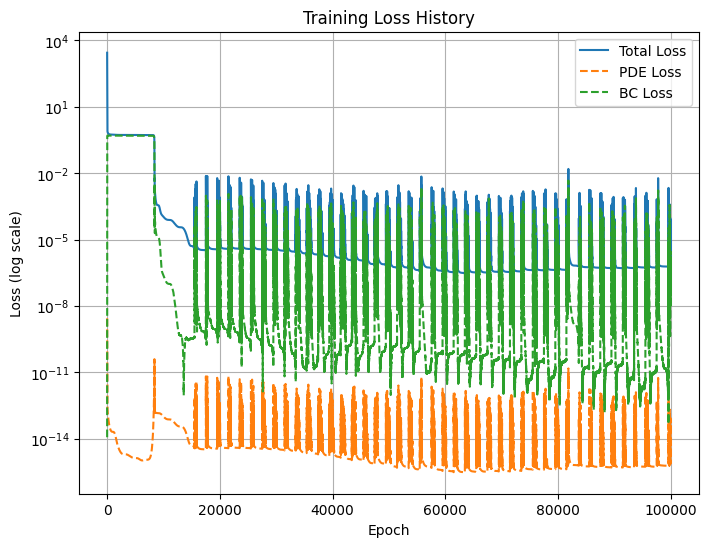

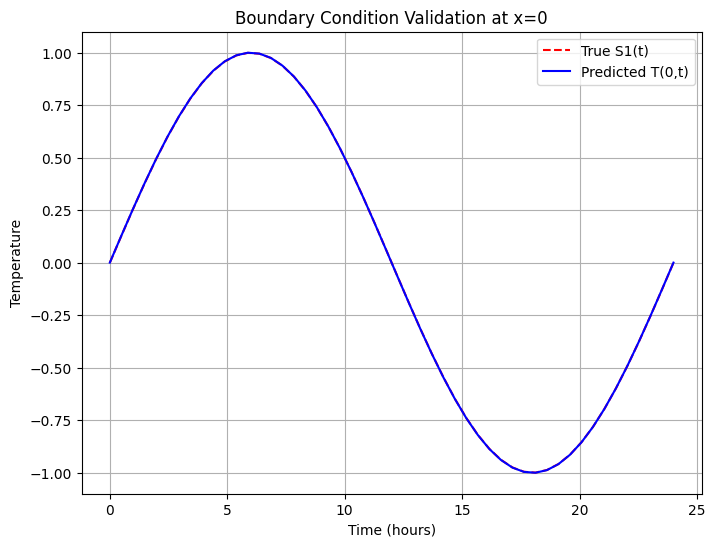

In [190]:
# ---------------------------
# 结果可视化
# ---------------------------
# 训练损失曲线
plt.figure(figsize=(8, 6))
plt.semilogy(model.loss_history, label='Total Loss')
plt.semilogy(model.pde_loss_history, '--', label='PDE Loss')
plt.semilogy(model.bc1_loss_history, '--', label='BC Loss')
# plt.semilogy(model.ic_loss_history, '--', label='IC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.show()

# 边界条件验证（x=0）
x_bc = np.zeros((num_t, 1))  # x=0处
A_pred, Phi_pred = model.predict(x_bc)
T_pred_bc = T0 + A_pred * np.sin(omega * t_vals + Phi_pred + phi0)
T_pred_bc = T_pred_bc[:,1]
plt.figure(figsize=(8, 6))
plt.plot(t_vals/3600, S1, 'r--', label='True S1(t)')
plt.plot(t_vals/3600, T_pred_bc, 'b-', label='Predicted T(0,t)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature')
plt.title('Boundary Condition Validation at x=0')
plt.legend()
plt.grid(True)
plt.show()

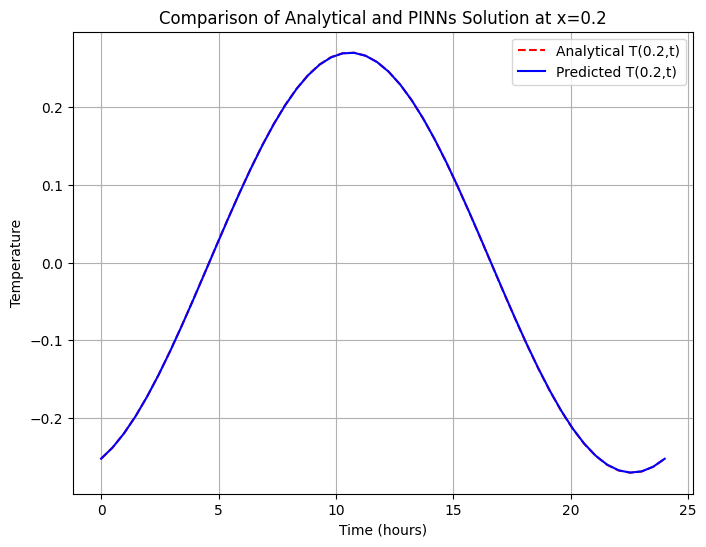

In [191]:
# 对比解析解和神经网络预测的解（x=0.2）
x_02 = 0.2 * np.ones_like(t_vals)  # x=0.2处，形状 (200, 1)
T_anal_02 = T_anal(x_02, t_vals, T0, A_anal, W_true, k_true, omega, phi0)  # 解析解，形状 (200, 1)

# 神经网络预测的 A 和 Φ
A_pred_02, Phi_pred_02 = model.predict(x_02)  # A_pred_02 和 Phi_pred_02 的形状应为 (200, 1)
# 确保 A_pred_02 和 Phi_pred_02 的形状正确
A_pred_02 = A_pred_02.reshape(-1, 1)  # 形状 (200, 1)
Phi_pred_02 = Phi_pred_02.reshape(-1, 1)  # 形状 (200, 1)

# 生成神经网络预测的解
T_pred_02 = T0 + A_pred_02 * np.sin(omega * t_vals + Phi_pred_02 + phi0)  # 形状 (200, 1)

# 绘制对比图
plt.figure(figsize=(8, 6))
plt.plot(t_vals/3600, T_anal_02, 'r--', label='Analytical T(0.2,t)')
plt.plot(t_vals/3600, T_pred_02, 'b-', label='Predicted T(0.2,t)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature')
plt.title('Comparison of Analytical and PINNs Solution at x=0.2')
plt.legend()
plt.grid(True)
plt.show()

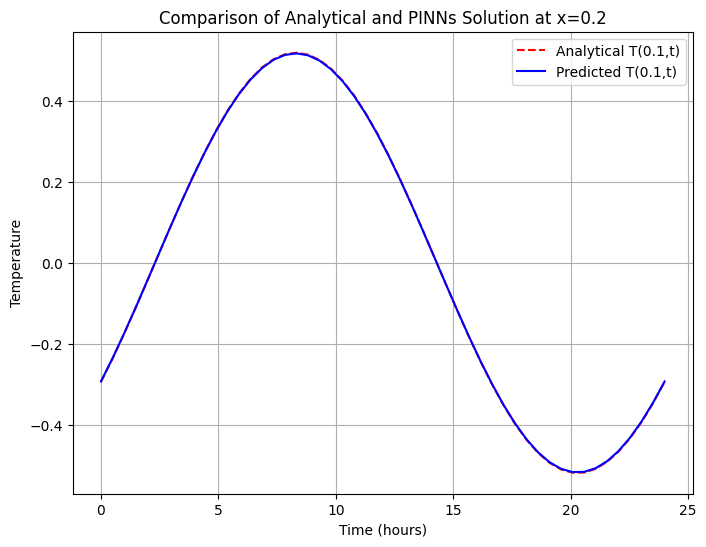

In [192]:
# 对比解析解和神经网络预测的解（x=0.1）
x_01 = 0.1 * np.ones_like(t_vals)  # x=0.2处，形状 (200, 1)
T_anal_01 = T_anal(x_01, t_vals, T0, A_anal, W_true, k_true, omega, phi0)  # 解析解，形状 (200, 1)

# 神经网络预测的 A 和 Φ
A_pred_01, Phi_pred_01 = model.predict(x_01)  # A_pred_02 和 Phi_pred_02 的形状应为 (200, 1)

# 确保 A_pred_02 和 Phi_pred_02 的形状正确
A_pred_01 = A_pred_01.reshape(-1, 1)  # 形状 (200, 1)
Phi_pred_01 = Phi_pred_01.reshape(-1, 1)  # 形状 (200, 1)

# 生成神经网络预测的解
T_pred_01 = T0 + A_pred_01 * np.sin(omega * t_vals + Phi_pred_01 + phi0)  # 形状 (200, 1)

# 绘制对比图
plt.figure(figsize=(8, 6))
plt.plot(t_vals/3600, T_anal_01, 'r--', label='Analytical T(0.1,t)')
plt.plot(t_vals/3600, T_pred_01, 'b-', label='Predicted T(0.1,t)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature')
plt.title('Comparison of Analytical and PINNs Solution at x=0.2')
plt.legend()
plt.grid(True)
plt.show()

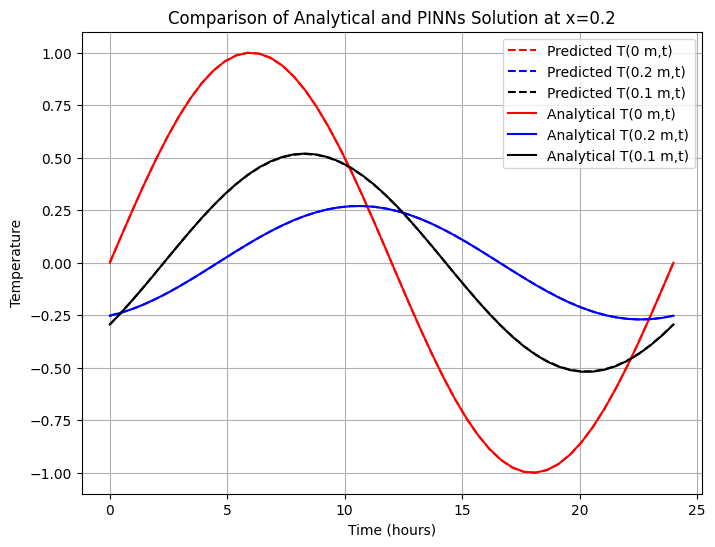

In [193]:
# 绘制对比图
plt.figure(figsize=(8, 6))
plt.plot(t_vals/3600, T_pred_bc, 'r--', label='Predicted T(0 m,t)')
plt.plot(t_vals/3600, T_pred_02, 'b--', label='Predicted T(0.2 m,t)')
plt.plot(t_vals/3600, T_pred_01, 'k--', label='Predicted T(0.1 m,t)')
plt.plot(t_vals/3600, S1, 'r-', label='Analytical T(0 m,t)')
plt.plot(t_vals/3600, T_anal_02, 'b-', label='Analytical T(0.2 m,t)')
plt.plot(t_vals/3600, T_anal_01, 'k-', label='Analytical T(0.1 m,t)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature')
plt.title('Comparison of Analytical and PINNs Solution at x=0.2')
plt.legend()
plt.grid(True)
plt.show()

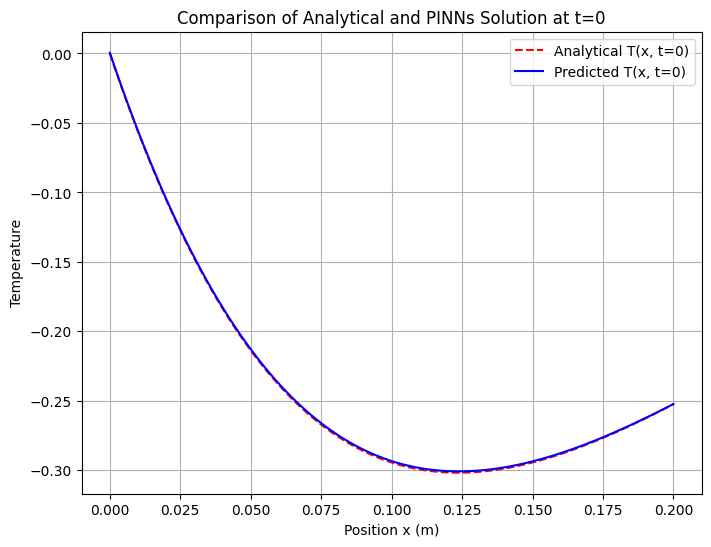

In [194]:
# ---------------------------
# 初始条件（IC）对比
# ---------------------------
# 在 t=0 时计算解析解和神经网络预测的解
t_ic = 0.0  # 初始时间
x_ic = np.linspace(x_min, x_max, num_x).reshape(-1, 1)  # 空间坐标

# 解析解在 t=0 时的值
T_anal_ic = T_anal(x_ic, t_ic, T0, A_anal, W_true, k_true, omega, phi0)

# 神经网络预测的 A 和 Φ
A_pred_ic, Phi_pred_ic = model.predict(x_ic)
# Phi_pred_ic = (Phi_pred_ic + torch.pi) % (2 * torch.pi) - torch.pi  # 变换到 [-π, π] 区间

# 生成神经网络预测的解
T_pred_ic = T0 + A_pred_ic * np.sin(omega * t_ic + Phi_pred_ic + phi0)

# 绘制初始条件对比图
plt.figure(figsize=(8, 6))
plt.plot(x_ic, T_anal_ic, 'r--', label='Analytical T(x, t=0)')
plt.plot(x_ic, T_pred_ic, 'b-', label='Predicted T(x, t=0)')
plt.xlabel('Position x (m)')
plt.ylabel('Temperature')
plt.title('Comparison of Analytical and PINNs Solution at t=0')
plt.legend()
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 0.0008


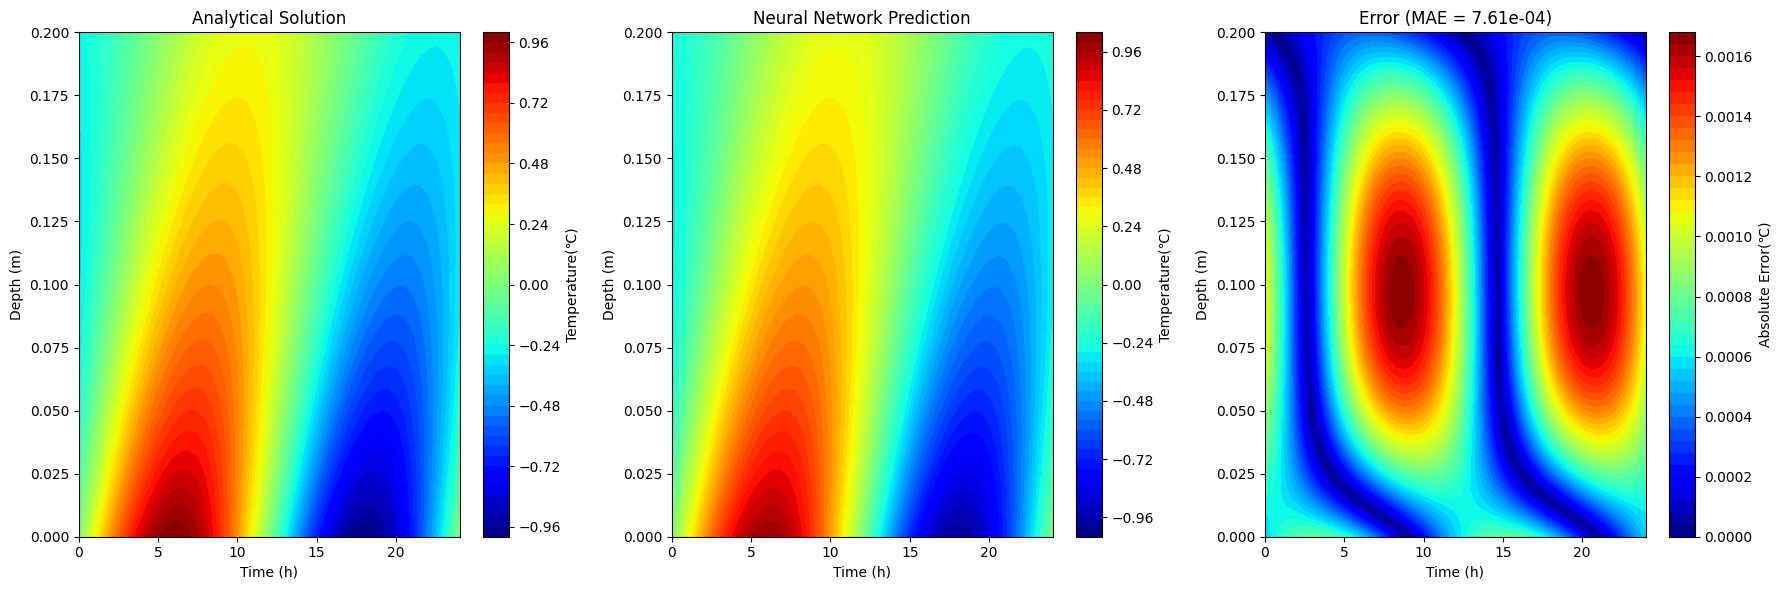

In [195]:
# ---------------------------
# 结果可视化与误差分析
# ---------------------------
def plot_comparison(model, x_vals, t_vals, T0, A_anal, W, k, omega, phi0):
    # 生成网格数据
    X, T = np.meshgrid(x_vals, t_vals)
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)

    # 使用神经网络预测
    model.dnn.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(X_flat, dtype=torch.float32, device=device)
        t_tensor = torch.tensor(T_flat, dtype=torch.float32, device=device)
        
        # 获取神经网络预测的 A(x) 和 Φ(x)
        outputs = model.dnn(x_tensor)
        A_pred = (outputs[:, 0].unsqueeze(1))  # A(x)
        A_pred = torch.exp(A_pred)
        Phi_pred = (outputs[:, 1].unsqueeze(1))   # Φ(x)
        Phi_pred = (Phi_pred + torch.pi) % (2 * torch.pi) - torch.pi  # 变换到 [-π, π] 区间
        
        # 计算预测的温度场
        phase_pred = model.omega * t_tensor + Phi_pred + model.phi0
        T_pred = model.T0 + A_pred * torch.sin(phase_pred)
        T_pred = T_pred.cpu().numpy().reshape(X.shape)

    # 计算解析解
    T_analytical = T_anal(X, T, T0, A_anal, W, k, omega, phi0)

    # 计算 MAE
    mae = np.mean(np.abs(T_pred - T_analytical))
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # 可视化
    plt.figure(figsize=(18, 6))

    # 解析解
    plt.subplot(1, 3, 1)
    plt.contourf(T/3600, X, T_analytical, levels=50, cmap='jet')
    plt.colorbar(label='Temperature(℃)')
    plt.xlabel('Time (h)')
    plt.ylabel('Depth (m)')
    plt.title('Analytical Solution')

    # 神经网络预测
    plt.subplot(1, 3, 2)
    plt.contourf(T/3600, X, T_pred, levels=50, cmap='jet')
    plt.colorbar(label='Temperature(℃)')
    plt.xlabel('Time (h)')
    plt.ylabel('Depth (m)')
    plt.title('Neural Network Prediction')

    # 误差图
    plt.subplot(1, 3, 3)
    error = np.abs(T_pred - T_analytical)
    plt.contourf(T/3600, X, error, levels=50, cmap='jet')
    plt.colorbar(label='Absolute Error(℃)')
    plt.xlabel('Time (h)')
    plt.ylabel('Depth (m)')
    plt.title(f'Error (MAE = {mae:.2e})')

    plt.tight_layout()
    plt.show()

# 调用可视化函数
plot_comparison(model, x_vals, t_vals, T0, A_anal, W_true, k_true, omega, phi0)